Data preparation
---

In this notebook, the raw data is prepared for further analysis and modelling, for instance by creating new features. 

The outbook from this notebook is saved as `data/processed/gdf.pkl`.

In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, LineString
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

### Read the raw data

Some file info:
```
$ head -n5 data/raw/train.csv 
key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.84161,40.712278,1
2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.76127,-73.991242,40.750562,2
2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.98713,40.733143,-73.991567,40.758092,1

$ wc -l data/raw/train.csv 
55423856 data/raw/train.csv

$ wc -l data/raw/test.csv
9914 data/raw/test.csv
```

From the above output, the order of the taxi trips seems to be random, hence the rows are read directly to a dataframe. The dtypes of the columns are specified directly to save some memory usage. (Note: May give a slight decrease in accuracy when modelling?)

In [2]:
large_calculations = False #If True, some calculations are not made (e.g. calculating taxi lines)
rotate_coordinates = False #Gives a slight improvement in the prediction if True (when coordinates are used as features)
export_data = True

columns_of_interest=['fare_amount', 'pickup_datetime', 'pickup_longitude',\
    'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude','passenger_count']

dtypes = {'passenger_count': np.uint8, 'fare_amount': np.float16,
            'pickup_longitude': np.float32, 'dropoff_longitude': np.float32,
            'pickup_latitude': np.float32, 'dropoff_latitude': np.float32}
df=pd.read_csv('data/raw/train.csv', #Note: the full training set can be downloaded from the Kaggle competition site
    nrows=100_000,
    usecols=columns_of_interest, parse_dates=['pickup_datetime'],
    #skiprows = lambda i: i % 5000 != 0
    #skiprows=range(1, 5_000_000), #Use this to create separate training sets which can later be merged before modelling
    dtype=dtypes)
print(df.info(memory_usage='deep'))
df.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
fare_amount          100000 non-null float16
pickup_datetime      100000 non-null datetime64[ns]
pickup_longitude     100000 non-null float32
pickup_latitude      100000 non-null float32
dropoff_longitude    100000 non-null float32
dropoff_latitude     100000 non-null float32
passenger_count      100000 non-null uint8
dtypes: datetime64[ns](1), float16(1), float32(4), uint8(1)
memory usage: 2.6 MB
None


,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
99995,9.000000,2013-09-24 07:39:00,-73.947975,40.784794,-73.964264,40.792347,5
99996,6.000000,2014-05-15 12:15:45,-73.962921,40.799107,-73.974174,40.786488,1
99997,5.000000,2015-02-19 17:40:43,-73.996773,40.723549,-73.991974,40.724724,1
99998,6.898438,2009-10-10 23:35:00,-73.983650,40.756668,-73.982712,40.767067,4
99999,5.699219,2010-11-09 16:09:00,-73.975662,40.791653,-73.982269,40.774967,1


### Select relevant data

The final prediction will be done on the Kaggle test set, hence a bounding box from this data is created to select only points within this box from the training set (perhaps a smaller box could have been chosen; the outliers far away from the city centre may disturb when training the model):

In [3]:
df_test = pd.read_csv('data/raw/test.csv',
            parse_dates=['pickup_datetime'],
            dtype=dtypes)
#Print coordinates so that a geojson-file can be created and visualised in QGIS:
print(df_test[['pickup_longitude','dropoff_longitude']].min(axis=1).min())
print(df_test[['pickup_longitude','dropoff_longitude']].max(axis=1).max())
print(df_test[['pickup_latitude','dropoff_latitude']].min(axis=1).min())
print(df_test[['pickup_latitude','dropoff_latitude']].max(axis=1).max())
df_test.tail()

-74.263245
-72.986534
40.568974
41.709557


,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
9909,2015-05-10 12:37:51.0000002,2015-05-10 12:37:51,-73.968124,40.796997,-73.955643,40.780388,6
9910,2015-01-12 17:05:51.0000001,2015-01-12 17:05:51,-73.945511,40.803600,-73.960213,40.776371,6
9911,2015-04-19 20:44:15.0000001,2015-04-19 20:44:15,-73.991600,40.726608,-73.789742,40.647011,6
9912,2015-01-31 01:05:19.0000005,2015-01-31 01:05:19,-73.985573,40.735432,-73.939178,40.801731,6
9913,2015-01-18 14:06:23.0000006,2015-01-18 14:06:23,-73.988022,40.754070,-74.000282,40.759220,6


In [4]:
bbox=(df_test[['pickup_longitude','dropoff_longitude']].min(axis=1).min(),
      df_test[['pickup_longitude','dropoff_longitude']].max(axis=1).max(),
      df_test[['pickup_latitude','dropoff_latitude']].min(axis=1).min(),
      df_test[['pickup_latitude','dropoff_latitude']].max(axis=1).max())
def select_within_bbox(df, bbox):
    min_lon=bbox[0]; max_lon=bbox[1]
    min_lat=bbox[2]; max_lat=bbox[3]
    df = df[(df.pickup_longitude>min_lon) & (df.pickup_longitude<max_lon) &\
            (df.dropoff_longitude>min_lon) & (df.dropoff_longitude<max_lon) &\
            (df.pickup_latitude>min_lat) & (df.pickup_latitude<max_lat) &\
            (df.dropoff_latitude>min_lat) & (df.dropoff_latitude<max_lat)]
    return df

print('Length before removing points outside bbox: ', len(df))
df = select_within_bbox(df, bbox)
print('Length after removing points outside bbox: ', len(df))
#Visualise

Length before removing points outside bbox:  100000
Length after removing points outside bbox:  97848


Test data with bounding box:

<img src="qgis/bbox.png" alt="drawing" width="600"/>

### Create GIS features

As will be shown in the notebook data_exploration.ipynb, the distance between pickup and dropoff is closely correlated with the taxi fare. For several taxi trips, however, the distance is misleading. As can be seen in the below figure, the actual distance between two locations may be much larger than the euclidian distance unless the taxi can sail on water. Also, the trip may be more expensive if the taxi crosses a bridge with tolls. In an attempt to handle this, new geographical features have been created for each pickup and dropoff location. The model will then not have to learn by itself that this and that lon/lat-combination is within Manhattan, Queens etc. Erroneous locations in the water has been kept as is for now.

<img src="qgis/distance.png" alt="drawing" width="800"/>

First, [geopandas](http://geopandas.org/) is used to create two separate GeoDataFrames for the pickups and dropoffs. Since the coordinates are in latitudes and longitudes, the coordinate reference system (crs) is specified to [WGS 84 / epsg:4326](http://spatialreference.org/ref/epsg/wgs-84/).

In [5]:
start_location = [Point(xy) for xy in zip(df['pickup_longitude'], df['pickup_latitude'])]
stop_location = [Point(xy) for xy in zip(df['dropoff_longitude'], df['dropoff_latitude'])]
crs={'init': 'epsg:4326'}
gdf_pickup=gpd.GeoDataFrame(df, crs=crs, geometry=start_location, copy=True) #Important with copy!
gdf_dropoff=gpd.GeoDataFrame(df, crs=crs, geometry=stop_location, copy=True)
gdf_pickup.tail()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,geometry
99995,9.000000,2013-09-24 07:39:00,-73.947975,40.784794,-73.964264,40.792347,5,POINT (-73.94797515869141 40.78479385375977)
99996,6.000000,2014-05-15 12:15:45,-73.962921,40.799107,-73.974174,40.786488,1,POINT (-73.96292114257812 40.79910659790039)
99997,5.000000,2015-02-19 17:40:43,-73.996773,40.723549,-73.991974,40.724724,1,POINT (-73.99677276611328 40.72354888916016)
99998,6.898438,2009-10-10 23:35:00,-73.983650,40.756668,-73.982712,40.767067,4,POINT (-73.98365020751953 40.75666809082031)
99999,5.699219,2010-11-09 16:09:00,-73.975662,40.791653,-73.982269,40.774967,1,POINT (-73.97566223144531 40.79165267944336)


The geodataframes will then be spatially joined with a shapefile which contains all boroughs and taxi zones in New York (obtained from [here](https://s3.amazonaws.com/nyc-tlc/misc/taxi_zones.zip), ref. [this analysis](https://towardsdatascience.com/geospatial-operations-at-scale-with-dask-and-geopandas-4d92d00eb7e8)). 

In [6]:
nyc_zones=gpd.read_file('data/raw/taxi_zones.shp')
nyc_zones.tail()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry
258,259,0.126750,0.000395,Woodlawn/Wakefield,259,Bronx,"POLYGON ((1025414.781960189 270986.1393638253,..."
259,260,0.133514,0.000422,Woodside,260,Queens,"POLYGON ((1011466.966050446 216463.0052037984,..."
260,261,0.027120,0.000034,World Trade Center,261,Manhattan,"POLYGON ((980555.2043112218 196138.486258477, ..."
261,262,0.049064,0.000122,Yorkville East,262,Manhattan,(POLYGON ((999804.7945504487 224498.5270484537...
262,263,0.037017,0.000066,Yorkville West,263,Manhattan,"POLYGON ((997493.3227153122 220912.3861623257,..."


{'init': 'epsg:2263'}


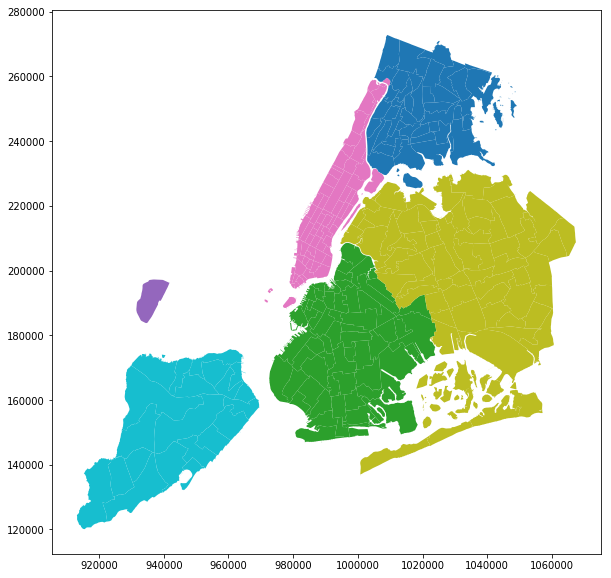

In [7]:
#Drop columns that are not to be used:
nyc_zones=nyc_zones.drop(columns=['OBJECTID','Shape_Leng','Shape_Area','LocationID'])
print(nyc_zones.crs)
nyc_zones.plot(column='borough',figsize=(10,10))

As can be seen from the output above, the crs for `nyc_zones` is [NAD83 / epsg:2263](http://spatialreference.org/ref/epsg/nad83-new-york-long-island-ftus/). In order to perform the spatial joining, the crs in the geodataframes and `nyc_zones` have to be equal; hence the crs for `nyc_zones` is reprojected to epsg:4326.

{'init': 'epsg:4326'}


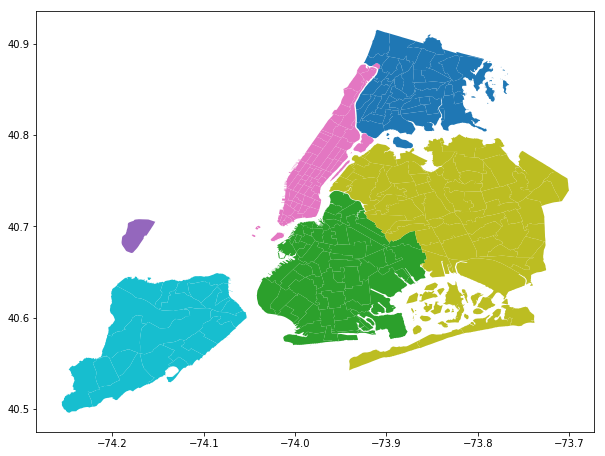

In [8]:
nyc_zones=nyc_zones.to_crs(crs={'init': 'epsg:4326'})
print(nyc_zones.crs)
nyc_zones.plot(column='borough',figsize=(10,10))

Now that the same coordinate reference system is used for the geodataframes and the shapefile, spatial joining can be performed to create the GeoDataFrame `gdf`.

In [9]:
pickup_with_boro = (gpd.sjoin(gdf_pickup, nyc_zones, how="left", op='intersects')
    .drop(['dropoff_longitude', 'dropoff_latitude'],axis='columns'))
dropoff_with_boro = gpd.sjoin(gdf_dropoff[['dropoff_longitude', 'dropoff_latitude','geometry']],
    nyc_zones, how="left", op='intersects')
gdf = pickup_with_boro.join(dropoff_with_boro,lsuffix='_pickup',rsuffix='_dropoff')
#Drop some columns
gdf=gdf.drop(columns=['index_right_pickup','index_right_dropoff'])
#Could perhaps also drop the latitude and longitude coordinates as these are cointained within
#geometry_pickup and geometry_dropoff.
gdf.tail()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,passenger_count,geometry_pickup,zone_pickup,borough_pickup,dropoff_longitude,dropoff_latitude,geometry_dropoff,zone_dropoff,borough_dropoff
99995,9.000000,2013-09-24 07:39:00,-73.947975,40.784794,5,POINT (-73.94797515869141 40.78479385375977),East Harlem South,Manhattan,-73.964264,40.792347,POINT (-73.96426391601562 40.7923469543457),Upper West Side North,Manhattan
99996,6.000000,2014-05-15 12:15:45,-73.962921,40.799107,1,POINT (-73.96292114257812 40.79910659790039),Manhattan Valley,Manhattan,-73.974174,40.786488,POINT (-73.97417449951172 40.7864875793457),Upper West Side South,Manhattan
99997,5.000000,2015-02-19 17:40:43,-73.996773,40.723549,1,POINT (-73.99677276611328 40.72354888916016),Little Italy/NoLiTa,Manhattan,-73.991974,40.724724,POINT (-73.99197387695312 40.72472381591797),East Village,Manhattan
99998,6.898438,2009-10-10 23:35:00,-73.983650,40.756668,4,POINT (-73.98365020751953 40.75666809082031),Times Sq/Theatre District,Manhattan,-73.982712,40.767067,POINT (-73.98271179199219 40.76706695556641),Clinton East,Manhattan
99999,5.699219,2010-11-09 16:09:00,-73.975662,40.791653,1,POINT (-73.97566223144531 40.79165267944336),Upper West Side North,Manhattan,-73.982269,40.774967,POINT (-73.98226928710938 40.77496719360352),Lincoln Square East,Manhattan


As can be seen from the above output, for each taxi trip there is now information on taxi zone and borough for the pickup and dropoff locations.

### Create linestrings
For visualisation purposes, it may be useful to connect the pickup and dropoffs with to create linestrings (*for large data sets this operation takes a long time*).

In [10]:
def createLineString(row):
    p1=row['geometry_pickup'].coords[0]
    p2=row['geometry_dropoff'].coords[0]
    return LineString([p1,p2])
if not large_calculations:
    gdf['taxi_line']=gdf.apply(createLineString, axis=1)

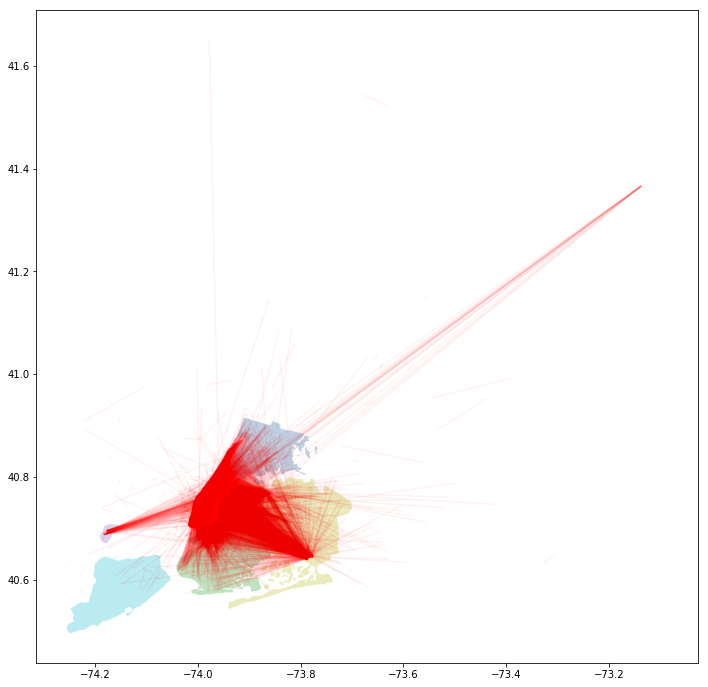

In [11]:
if not large_calculations:
    f, ax = plt.subplots(figsize=(15,12))
    nyc_zones.plot(column='borough',alpha=0.3,ax=ax)
    gdf.set_geometry('taxi_line').plot(alpha=0.05, color='red',ax=ax)

### Missing values - create more boroughs

In [12]:
print('No. of taxi trips: {} \n'.format(len(gdf)))
print('NaN values: \n\n{}'.format(gdf.isna().sum()))

No. of taxi trips: 97848 

NaN values: 

fare_amount            0
pickup_datetime        0
pickup_longitude       0
pickup_latitude        0
passenger_count        0
geometry_pickup        0
zone_pickup          341
borough_pickup       341
dropoff_longitude      0
dropoff_latitude       0
geometry_dropoff       0
zone_dropoff         429
borough_dropoff      429
taxi_line              0
dtype: int64


As the above list shows, several of the taxi trips do not have values for *borough_pickup* or *borough_dropoff*. In the below figure, it is seen that most of these locations are to the west of Manhattan. It is possible to assign these locations to their nearest borough, or new "boroughs" can be created. 
The latter approach is here chosen, i.e. creating a new borough to the west of Manhattan.

<img src="qgis/boroughs.png" alt="drawing" width="800"/>

First create a geopackage layer (or shapefile) in QGIS with a polygon covering the desired area (here called "West New York"):

<img src="qgis/wny.png" alt="drawing" width="800"/>

.. then read the file and join with gdf:

In [13]:
WNY = gpd.read_file('qgis/nyc_geodatabase.gpkg')
WNY=WNY.to_crs(crs={'init': 'epsg:4326'})
#Join on gdf:
pickups_from_WNY=gpd.sjoin(gdf.set_geometry('geometry_pickup'),WNY, how='inner', op='within').index
dropoffs_from_WNY=gpd.sjoin(gdf.set_geometry('geometry_dropoff'),WNY, how='inner', op='within').index
print('Index of trips with pickup within WNY:\n{}\n'.format(pickups_from_WNY))
print('Index of trips with dropoff within WNY:\n{}\n'.format(dropoffs_from_WNY))

Index of trips with pickup within WNY:
Int64Index([  105,   614,  1494,  2346,  4776,  7096,  9090,  9775, 10229,
            10485,
            ...
            93821, 94812, 94822, 95168, 96283, 97183, 98552, 98896, 99159,
            99986],
           dtype='int64', length=140)

Index of trips with dropoff within WNY:
Int64Index([  105,   846,  1494,  2346,  3035,  3843,  3946,  3989,  4776,
             7801,
            ...
            94822, 95168, 95850, 96283, 97602, 98093, 98552, 98896, 99229,
            99986],
           dtype='int64', length=186)



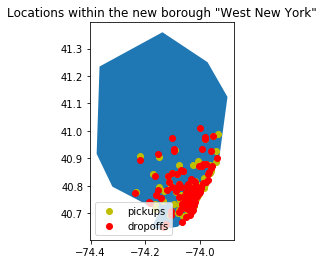

In [14]:
gdf.loc[pickups_from_WNY,'borough_pickup'] = 'West New York'
gdf.loc[pickups_from_WNY,'zone_pickup'] = 'West New York'
gdf.loc[dropoffs_from_WNY,'borough_dropoff'] = 'West New York'
gdf.loc[dropoffs_from_WNY,'zone_dropoff'] = 'West New York'
if not large_calculations:
    f,ax=plt.subplots()
    WNY.plot(ax=ax)
    gdf.set_geometry('geometry_pickup')[gdf.borough_pickup=='West New York'].plot(color='y',label='pickups',ax=ax)
    gdf.set_geometry('geometry_dropoff')[gdf.borough_dropoff=='West New York'].plot(color='r',label='dropoffs',ax=ax)
    plt.title('Locations within the new borough "West New York"')
    plt.legend(loc='lower left')

Similarly, more boroughs can be created:

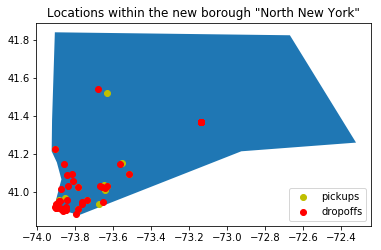

In [15]:
NNY = gpd.read_file('qgis/nyc_geodatabase.gpkg',layer='North_NY')
NNY=NNY.to_crs(crs={'init': 'epsg:4326'})
pickups_from_NNY=gpd.sjoin(gdf.set_geometry('geometry_pickup'),NNY, how='inner', op='within').index
dropoffs_from_NNY=gpd.sjoin(gdf.set_geometry('geometry_dropoff'),NNY, how='inner', op='within').index
gdf.loc[pickups_from_NNY,'borough_pickup'] = 'North New York'
gdf.loc[pickups_from_NNY,'zone_pickup'] = 'North New York'
gdf.loc[dropoffs_from_NNY,'borough_dropoff'] = 'North New York'
gdf.loc[dropoffs_from_NNY,'zone_dropoff'] = 'North New York'
if not large_calculations:
    f,ax=plt.subplots()
    NNY.plot(ax=ax)
    gdf.set_geometry('geometry_pickup')[gdf.borough_pickup=='North New York'].plot(color='y',label='pickups',ax=ax)
    gdf.set_geometry('geometry_dropoff')[gdf.borough_dropoff=='North New York'].plot(color='r',label='dropoffs',ax=ax)
    plt.title('Locations within the new borough "North New York"')
    plt.legend(loc='lower right')

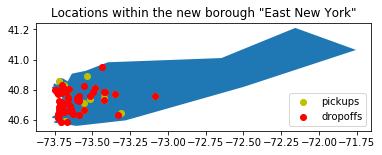

In [16]:
ENY = gpd.read_file('qgis/nyc_geodatabase.gpkg',layer='East_NY')
ENY=ENY.to_crs(crs={'init': 'epsg:4326'})
pickups_from_ENY=gpd.sjoin(gdf.set_geometry('geometry_pickup'),ENY, how='inner', op='within').index
dropoffs_from_ENY=gpd.sjoin(gdf.set_geometry('geometry_dropoff'),ENY, how='inner', op='within').index
gdf.loc[pickups_from_ENY,'borough_pickup'] = 'East New York'
gdf.loc[pickups_from_ENY,'zone_pickup'] = 'East New York'
gdf.loc[dropoffs_from_ENY,'borough_dropoff'] = 'East New York'
gdf.loc[dropoffs_from_ENY,'zone_dropoff'] = 'East New York'
if not large_calculations:
    f,ax=plt.subplots()
    ENY.plot(ax=ax)
    gdf.set_geometry('geometry_pickup')[gdf.borough_pickup=='East New York'].plot(color='y',label='pickups',ax=ax)
    gdf.set_geometry('geometry_dropoff')[gdf.borough_dropoff=='East New York'].plot(color='r',label='dropoffs',ax=ax)
    plt.title('Locations within the new borough "East New York"')
    plt.legend(loc='lower right')

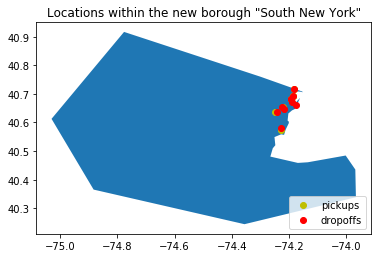

In [17]:
SNY = gpd.read_file('qgis/nyc_geodatabase.gpkg',layer='South_NY')
SNY=SNY.to_crs(crs={'init': 'epsg:4326'})
pickups_from_SNY=gpd.sjoin(gdf.set_geometry('geometry_pickup'),SNY, how='inner', op='within').index
dropoffs_from_SNY=gpd.sjoin(gdf.set_geometry('geometry_dropoff'),SNY, how='inner', op='within').index
gdf.loc[pickups_from_SNY,'borough_pickup'] = 'South New York'
gdf.loc[pickups_from_SNY,'zone_pickup'] = 'South New York'
gdf.loc[dropoffs_from_SNY,'borough_dropoff'] = 'South New York'
gdf.loc[dropoffs_from_SNY,'zone_dropoff'] = 'South New York'
if not large_calculations:
    f,ax=plt.subplots()
    SNY.plot(ax=ax)
    gdf.set_geometry('geometry_pickup')[gdf.borough_pickup=='South New York'].plot(color='y',label='pickups',ax=ax)
    gdf.set_geometry('geometry_dropoff')[gdf.borough_dropoff=='South New York'].plot(color='r',label='dropoffs',ax=ax)
    plt.title('Locations within the new borough "South New York"')
    plt.legend(loc='lower right')

In [18]:
print('Remaining NaN values: {}'.format(gdf.isna().any().sum()))

Remaining NaN values: 4


The remaining NaN-values for trips that are not within a borough have been given the borough 'No borough' (most of these will probably be in the water and could also have been removed from the dataframe).

In [19]:
gdf.loc[gdf['borough_pickup'].isna(),'borough_pickup'] = 'No borough'
gdf.loc[gdf['zone_pickup'].isna(),'zone_pickup'] = 'No zone'
gdf.loc[gdf['borough_dropoff'].isna(),'borough_dropoff'] = 'No borogh'
gdf.loc[gdf['zone_dropoff'].isna(),'zone_dropoff'] = 'No zone'
print('Remaining NaN values: {}'.format(gdf.isna().any().sum()))

Remaining NaN values: 0


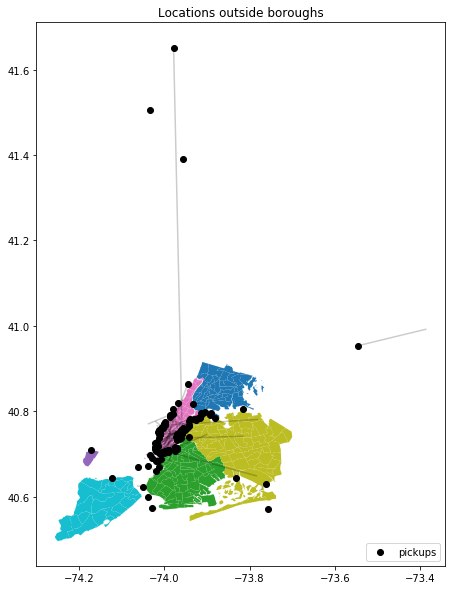

In [20]:
if not large_calculations:
    f,ax=plt.subplots(figsize=(10,10))
    nyc_zones.plot(column='borough',ax=ax)
#     WNY.plot(ax=ax)
#     NNY.plot(ax=ax)
#     ENY.plot(ax=ax)
#     SNY.plot(ax=ax)
    gdf.set_geometry('geometry_pickup')[gdf['borough_pickup']=='No borough'].plot(color='black',label='pickups',ax=ax)
    gdf.set_geometry('geometry_dropoff')[gdf['borough_dropoff']=='No borough'].plot(color='r',label='dropoffs',ax=ax)
    gdf.set_geometry('taxi_line')[gdf['borough_pickup']=='No borough'].plot(alpha=0.2, color='black',ax=ax)
    gdf.set_geometry('taxi_line')[gdf['borough_dropoff']=='No borough'].plot(alpha=0.2, color='black',ax=ax)
    plt.title('Locations outside boroughs')
    plt.legend(loc='lower right')

### Manhattan features
Also divide Manhattan into four parts, i.e. let the model know if the pickup/dropoff location is in "South Manhattan", "Middle-South Manhattan", "North Manhattan" or "Middle-North Manhattan".

<img src="qgis/manhattan_zones.png" alt="drawing" width="400"/>

In [21]:
MS = gpd.read_file('qgis/nyc_geodatabase.gpkg',layer='Manhattan_South')
MS=MS.to_crs(crs={'init': 'epsg:4326'})
pickups_from_MS=gpd.sjoin(gdf.set_geometry('geometry_pickup'),MS, how='inner', op='within').index
dropoffs_from_MS=gpd.sjoin(gdf.set_geometry('geometry_dropoff'),MS, how='inner', op='within').index
gdf.loc[pickups_from_MS,'pickup_Manhattan_South'] = True
gdf.loc[dropoffs_from_MS,'dropoff_Manhattan_South'] = True

MN = gpd.read_file('qgis/nyc_geodatabase.gpkg',layer='Manhattan_North')
MN=MN.to_crs(crs={'init': 'epsg:4326'})
pickups_from_MN=gpd.sjoin(gdf.set_geometry('geometry_pickup'),MN, how='inner', op='within').index
dropoffs_from_MN=gpd.sjoin(gdf.set_geometry('geometry_dropoff'),MN, how='inner', op='within').index
gdf.loc[pickups_from_MN,'pickup_Manhattan_North'] = True
gdf.loc[dropoffs_from_MN,'dropoff_Manhattan_North'] = True

MMN = gpd.read_file('qgis/nyc_geodatabase.gpkg',layer='Manhattan_MN')
MMN=MMN.to_crs(crs={'init': 'epsg:4326'})
pickups_from_MMN=gpd.sjoin(gdf.set_geometry('geometry_pickup'),MMN, how='inner', op='within').index
dropoffs_from_MMN=gpd.sjoin(gdf.set_geometry('geometry_dropoff'),MMN, how='inner', op='within').index
gdf.loc[pickups_from_MMN,'pickup_Manhattan_MNorth'] = True
gdf.loc[dropoffs_from_MMN,'dropoff_Manhattan_MNorth'] = True

MMS = gpd.read_file('qgis/nyc_geodatabase.gpkg',layer='Manhattan_MS')
MMS=MMS.to_crs(crs={'init': 'epsg:4326'})
pickups_from_MMS=gpd.sjoin(gdf.set_geometry('geometry_pickup'),MMS, how='inner', op='within').index
dropoffs_from_MMS=gpd.sjoin(gdf.set_geometry('geometry_dropoff'),MMS, how='inner', op='within').index
gdf.loc[pickups_from_MMS,'pickup_Manhattan_MSouth'] = True
gdf.loc[dropoffs_from_MMS,'dropoff_Manhattan_MSouth'] = True

In [22]:
#Fill NaN-values with False:
gdf[['pickup_Manhattan_South','dropoff_Manhattan_South', 'pickup_Manhattan_North', 'dropoff_Manhattan_North', 'pickup_Manhattan_MNorth',
   'dropoff_Manhattan_MNorth', 'pickup_Manhattan_MSouth', 'dropoff_Manhattan_MSouth']]=gdf[['pickup_Manhattan_South','dropoff_Manhattan_South', 'pickup_Manhattan_North', 'dropoff_Manhattan_North', 'pickup_Manhattan_MNorth',
   'dropoff_Manhattan_MNorth', 'pickup_Manhattan_MSouth', 'dropoff_Manhattan_MSouth']].fillna(False)

In [23]:
gdf.tail()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,passenger_count,geometry_pickup,zone_pickup,borough_pickup,dropoff_longitude,dropoff_latitude,...,borough_dropoff,taxi_line,pickup_Manhattan_South,dropoff_Manhattan_South,pickup_Manhattan_North,dropoff_Manhattan_North,pickup_Manhattan_MNorth,dropoff_Manhattan_MNorth,pickup_Manhattan_MSouth,dropoff_Manhattan_MSouth
99995,9.000000,2013-09-24 07:39:00,-73.947975,40.784794,5,POINT (-73.94797515869141 40.78479385375977),East Harlem South,Manhattan,-73.964264,40.792347,...,Manhattan,LINESTRING (-73.94797515869141 40.784793853759...,False,False,False,False,True,True,False,False
99996,6.000000,2014-05-15 12:15:45,-73.962921,40.799107,1,POINT (-73.96292114257812 40.79910659790039),Manhattan Valley,Manhattan,-73.974174,40.786488,...,Manhattan,LINESTRING (-73.96292114257812 40.799106597900...,False,False,False,False,True,True,False,False
99997,5.000000,2015-02-19 17:40:43,-73.996773,40.723549,1,POINT (-73.99677276611328 40.72354888916016),Little Italy/NoLiTa,Manhattan,-73.991974,40.724724,...,Manhattan,LINESTRING (-73.99677276611328 40.723548889160...,True,False,False,False,False,False,False,True
99998,6.898438,2009-10-10 23:35:00,-73.983650,40.756668,4,POINT (-73.98365020751953 40.75666809082031),Times Sq/Theatre District,Manhattan,-73.982712,40.767067,...,Manhattan,LINESTRING (-73.98365020751953 40.756668090820...,False,False,False,False,False,False,True,True
99999,5.699219,2010-11-09 16:09:00,-73.975662,40.791653,1,POINT (-73.97566223144531 40.79165267944336),Upper West Side North,Manhattan,-73.982269,40.774967,...,Manhattan,LINESTRING (-73.97566223144531 40.791652679443...,False,False,False,False,True,True,False,False


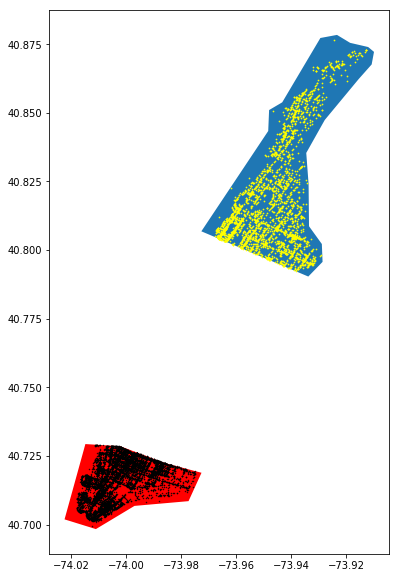

In [24]:
#Check that the Manhattan features have been created correctly:
f,ax=plt.subplots(figsize=(10,10))
MS.plot(color='red',ax=ax)
MN.plot(ax=ax)
gdf.set_geometry('geometry_dropoff')[gdf.dropoff_Manhattan_South==True].plot(color='black',label='dropoffs', markersize=0.2,ax=ax)
gdf.set_geometry('geometry_dropoff')[gdf.dropoff_Manhattan_North==True].plot(color='yellow',label='dropoffs', markersize=0.5,ax=ax)
#gdf.set_geometry('geometry_pickup')[gdf.pickup_Manhattan_South==True].plot(color='green',label='dropoffs', markersize=0.2,ax=ax)
#gdf.set_geometry('geometry_pickup')[gdf.pickup_Manhattan_North==True].plot(color='green',label='dropoffs', markersize=0.2,ax=ax)

### Create more features

#### Time features

Time features such as hour of day, weekday etc. can be extracted directly from the column `pickup_datetime`. The features `hour` and `month` are then mapped to a circle, so as to e.g. let the model know that 23:00 and 00:00 are close to each other (see e.g. [this](http://blog.davidkaleko.com/feature-engineering-cyclical-features.html) link). Weekday is treated as a categorical feature when modelling, though this feature also is cyclic feature.

In [25]:
gdf['year']=gdf['pickup_datetime'].dt.year
gdf['month']=gdf['pickup_datetime'].dt.month
gdf['weekday']=gdf['pickup_datetime'].dt.day_name()
gdf['hour']=gdf['pickup_datetime'].dt.hour

gdf['hr_sin'] = np.sin(gdf.hour*(2.*np.pi/24))
gdf['hr_cos'] = np.cos(gdf.hour*(2.*np.pi/24))
gdf['mnth_sin'] = np.sin((gdf.month-1)*(2.*np.pi/12))
gdf['mnth_cos'] = np.cos((gdf.month-1)*(2.*np.pi/12))

#### Distance features
In order to calculate the distance in meters, an appropriate coordinate system with grid in meters must be used. For New York, [NAD83 / epsg:26918](http://spatialreference.org/ref/epsg/26918/) may be used. The lat/lon coordinates are hence first transformed to this coordinate system before calculating the distances between pickups and dropoffs (note that when modelling the distance does not have to be in meters, but it is more convenient when interpreting results).

For taxi trips within Manhattan, the [Manhattan distance](https://en.wikipedia.org/wiki/Taxicab_geometry) is used, whereas eucledian distance is used for all other taxi trips. Before calculating the Manhattan distance, the coordinates have been transformed by [29 degrees](https://en.wikipedia.org/wiki/Manhattanhenge) to a "straight grid" so that the Manhattan distance can be calculated correctly.

In [26]:
from geopy.distance import vincenty
from shapely.ops import transform
from functools import partial
import pyproj

def transform_point(point, input_crs, output_crs):
    '''Transform point from input_crs to output_crs'''
    project = partial(
    pyproj.transform,
    pyproj.Proj(init=input_crs),
    pyproj.Proj(init=output_crs))
    return transform(project,point)

def rotate_point(point, phi):
    '''Rotate point around phi'''
    x=point.coords[0][0]
    y=point.coords[0][1]
    x_rot = x*np.cos(phi) - y*np.sin(phi)
    y_rot = x*np.sin(phi)+ y*np.cos(phi)
    return Point(x_rot, y_rot)

def euclidean_distance(row, input_crs, output_crs):
    '''Calculate distance between geometry_pickup and geometry_dropoff'''
    p1=transform_point(row['geometry_pickup'], input_crs='epsg:4326', output_crs='epsg:26918')
    p2=transform_point(row['geometry_dropoff'], input_crs='epsg:4326', output_crs='epsg:26918')
    return p1.distance(p2)

def manhattan_distance(row, input_crs, output_crs, cols):
    '''Calculate distance between two geometry columns'''
    p1=transform_point(row[cols[0]], input_crs='epsg:4326', output_crs='epsg:26918')
    p2=transform_point(row[cols[1]], input_crs='epsg:4326', output_crs='epsg:26918')
    lon1=p1.coords[0][0]
    lon2=p2.coords[0][0]
    lat1=p1.coords[0][1]
    lat2=p2.coords[0][1]
    return np.abs(lon2 - lon1) + np.abs(lat2 - lat1)

In [27]:
phi=np.deg2rad(29)
gdf['rot_pickup']=gdf['geometry_pickup'].apply(lambda x: rotate_point(x,phi))
gdf['rot_dropoff']=gdf['geometry_dropoff'].apply(lambda x: rotate_point(x,phi))

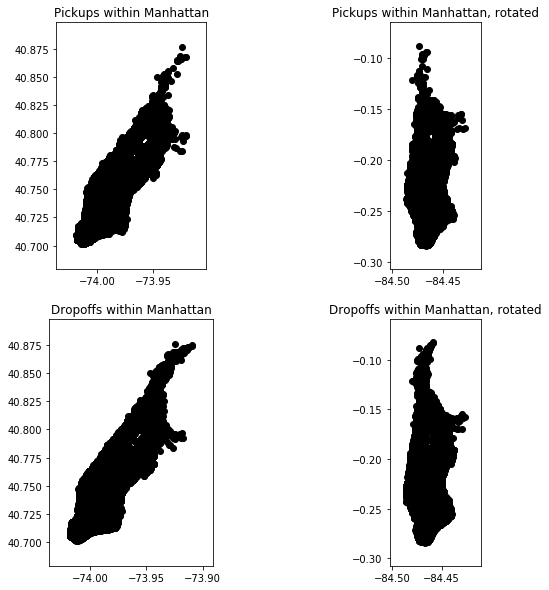

In [28]:
if not large_calculations:
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(10,10))
    gdf.set_geometry('geometry_pickup')[(gdf.borough_pickup == 'Manhattan') & (gdf.borough_dropoff == 'Manhattan')].plot(label='pickup',color='black',ax=ax1)
    ax1.set_title('Pickups within Manhattan')
    gdf.set_geometry('rot_pickup')[(gdf.borough_pickup == 'Manhattan') & (gdf.borough_dropoff == 'Manhattan')].plot(label='pickup',color='black',ax=ax2)
    ax2.set_title('Pickups within Manhattan, rotated')
    gdf.set_geometry('geometry_dropoff')[(gdf.borough_pickup == 'Manhattan') & (gdf.borough_dropoff == 'Manhattan')].plot(label='pickup',color='black',ax=ax3)
    ax3.set_title('Dropoffs within Manhattan')
    gdf.set_geometry('rot_dropoff')[(gdf.borough_pickup == 'Manhattan') & (gdf.borough_dropoff == 'Manhattan')].plot(label='pickup',color='black',ax=ax4)
    ax4.set_title('Dropoffs within Manhattan, rotated')

In [29]:
#Ideally apply over axis=1 should be avoided..
gdf['eucl_distance'] = gdf.apply(euclidean_distance, input_crs='epsg:4326', output_crs='epsg:26918', axis=1)
gdf['manhattan_distance'] = gdf.apply(manhattan_distance, input_crs='epsg:4326', output_crs='epsg:26918', 
                                              cols=['geometry_pickup','geometry_dropoff'], axis=1)
gdf['rotated_manhattan_distance'] = gdf.apply(manhattan_distance, input_crs='epsg:4326', output_crs='epsg:26918', 
                                              cols=['rot_pickup','rot_dropoff'], axis=1)
gdf.tail()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,passenger_count,geometry_pickup,zone_pickup,borough_pickup,dropoff_longitude,dropoff_latitude,...,hour,hr_sin,hr_cos,mnth_sin,mnth_cos,rot_pickup,rot_dropoff,eucl_distance,manhattan_distance,rotated_manhattan_distance
99995,9.000000,2013-09-24 07:39:00,-73.947975,40.784794,5,POINT (-73.94797515869141 40.78479385375977),East Harlem South,Manhattan,-73.964264,40.792347,...,7,9.659258e-01,-0.258819,-0.866025,-5.000000e-01,POINT (-84.4492167969124 -0.1795052985547514),POINT (-84.46712508089973 -0.1807961541849252),1610.002262,2206.388708,2166.026022
99996,6.000000,2014-05-15 12:15:45,-73.962921,40.799107,1,POINT (-73.96292114257812 40.79910659790039),Manhattan Valley,Manhattan,-73.974174,40.786488,...,12,1.224647e-16,-1.000000,0.866025,-5.000000e-01,POINT (-84.46922780501382 -0.1742330472384452),POINT (-84.47295239116603 -0.1907256252526039),1692.349227,2344.909257,2267.749621
99997,5.000000,2015-02-19 17:40:43,-73.996773,40.723549,1,POINT (-73.99677276611328 40.72354888916016),Little Italy/NoLiTa,Manhattan,-73.991974,40.724724,...,17,-9.659258e-01,-0.258819,0.500000,8.660254e-01,POINT (-84.46220399799529 -0.2567289010797538),POINT (-84.45857641075871 -0.2533747393515853),425.778566,538.853841,785.166538
99998,6.898438,2009-10-10 23:35:00,-73.983650,40.756668,4,POINT (-73.98365020751953 40.75666809082031),Times Sq/Theatre District,Manhattan,-73.982712,40.767067,...,23,-2.588190e-01,0.965926,-1.000000,-1.836970e-16,POINT (-84.46678325722083 -0.2214002519745648),POINT (-84.47100397017567 -0.2118502470603048),1157.143962,1221.100174,1546.806067
99999,5.699219,2010-11-09 16:09:00,-73.975662,40.791653,1,POINT (-73.97566223144531 40.79165267944336),Upper West Side North,Manhattan,-73.982269,40.774967,...,16,-8.660254e-01,-0.500000,-0.866025,5.000000e-01,POINT (-84.47675768105097 -0.1869293936716048),POINT (-84.47444705808729 -0.2047260125577708),1934.432255,2394.641011,2256.141409


Create a final feature "combined_distance" which is the Manhattan distance for taxi trips on Manhattan, and the euclidean distance for all other trips.

In [30]:
gdf['combined_distance']=np.where((gdf.borough_pickup == 'Manhattan') & (gdf.borough_dropoff == 'Manhattan'),gdf.rotated_manhattan_distance,gdf.eucl_distance)

In [31]:
if rotate_coordinates:
    gdf['pickup_longitude']=gdf.rot_pickup.apply(lambda x: x.coords[0][0])
    gdf['pickup_latitude']=gdf.rot_pickup.apply(lambda x: x.coords[0][1])
    gdf['dropoff_longitude']=gdf.rot_dropoff.apply(lambda x: x.coords[0][0])
    gdf['dropoff_latitude']=gdf.rot_dropoff.apply(lambda x: x.coords[0][1])

#### Airport features

Also create airport features (as is shown in data_exploration.ipynb, often a fixed price is used for trips to or from the airports).

In [32]:
nyc_zones[nyc_zones['zone'].str.contains('Airport')]

,zone,borough,geometry
0,Newark Airport,EWR,POLYGON ((-74.18445299999996 40.69499599999989...
131,JFK Airport,Queens,(POLYGON ((-73.8250346749999 40.66358013399983...
137,LaGuardia Airport,Queens,(POLYGON ((-73.87124856242509 40.7860381512549...


In [33]:
gdf['JFK_airport']=np.where((gdf['zone_pickup']=='JFK Airport') | (gdf['zone_dropoff']=='JFK Airport'),1,0)
gdf['Newark_airport']=np.where((gdf['zone_pickup']=='Newark Airport') | (gdf['zone_dropoff']=='Newark Airport'),1,0)
gdf['LaGuardia_airport']=np.where((gdf['zone_pickup']=='LaGuardia Airport') | (gdf['zone_dropoff']=='LaGuardia Airport'),1,0)
gdf.tail()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,passenger_count,geometry_pickup,zone_pickup,borough_pickup,dropoff_longitude,dropoff_latitude,...,mnth_cos,rot_pickup,rot_dropoff,eucl_distance,manhattan_distance,rotated_manhattan_distance,combined_distance,JFK_airport,Newark_airport,LaGuardia_airport
99995,9.000000,2013-09-24 07:39:00,-73.947975,40.784794,5,POINT (-73.94797515869141 40.78479385375977),East Harlem South,Manhattan,-73.964264,40.792347,...,-5.000000e-01,POINT (-84.4492167969124 -0.1795052985547514),POINT (-84.46712508089973 -0.1807961541849252),1610.002262,2206.388708,2166.026022,2166.026022,0,0,0
99996,6.000000,2014-05-15 12:15:45,-73.962921,40.799107,1,POINT (-73.96292114257812 40.79910659790039),Manhattan Valley,Manhattan,-73.974174,40.786488,...,-5.000000e-01,POINT (-84.46922780501382 -0.1742330472384452),POINT (-84.47295239116603 -0.1907256252526039),1692.349227,2344.909257,2267.749621,2267.749621,0,0,0
99997,5.000000,2015-02-19 17:40:43,-73.996773,40.723549,1,POINT (-73.99677276611328 40.72354888916016),Little Italy/NoLiTa,Manhattan,-73.991974,40.724724,...,8.660254e-01,POINT (-84.46220399799529 -0.2567289010797538),POINT (-84.45857641075871 -0.2533747393515853),425.778566,538.853841,785.166538,785.166538,0,0,0
99998,6.898438,2009-10-10 23:35:00,-73.983650,40.756668,4,POINT (-73.98365020751953 40.75666809082031),Times Sq/Theatre District,Manhattan,-73.982712,40.767067,...,-1.836970e-16,POINT (-84.46678325722083 -0.2214002519745648),POINT (-84.47100397017567 -0.2118502470603048),1157.143962,1221.100174,1546.806067,1546.806067,0,0,0
99999,5.699219,2010-11-09 16:09:00,-73.975662,40.791653,1,POINT (-73.97566223144531 40.79165267944336),Upper West Side North,Manhattan,-73.982269,40.774967,...,5.000000e-01,POINT (-84.47675768105097 -0.1869293936716048),POINT (-84.47444705808729 -0.2047260125577708),1934.432255,2394.641011,2256.141409,2256.141409,0,0,0


### Other areas

There are a few taxi trips to the very North-East of NY. A new feature `is_north` is created for these trips (another approach might be better, e.g. treat these trips as outliers and remove them before training).

In [34]:
gdf['is_north']=np.where((gdf.pickup_latitude>41.2) | (gdf.dropoff_latitude>41.2),1,0)
gdf.is_north.sum()

45

### Remove outliers

Taxi trips with a fare amount less than 2.5 dollar has been removed (the initial charge is [2.5 dollar](http://www.nyc.gov/html/tlc/downloads/pdf/taxi_information.pdf)).  It is tempting also to remove trips with zero distance, but as is shown in data exploration notebook, their respective fare_amount is not zero, and the number of trips with zero distance is significant.

In [35]:
print("Number of trips with fare amount < $2.5: {}".format(len(gdf[gdf.fare_amount<2.5])))
n_zero_distance = len(gdf[gdf['eucl_distance']==0])
cut_off_fare = 750
print("Number of trips with zero distance: {}".format(n_zero_distance))
n_expensive_fares = len(gdf[gdf['fare_amount'] > cut_off_fare])
print("Number of trips with fare_amount > {}: {}".format(cut_off_fare, n_expensive_fares))
#Remove the outliers
gdf = gdf[(gdf.fare_amount>2.5) & (gdf.fare_amount < cut_off_fare)]

Number of trips with fare amount < $2.5: 13
Number of trips with zero distance: 1085
Number of trips with fare_amount > 750: 0


### Test: Distance to airports instead of lat/lon+airport features
LightGBM can triangulate between the three points somehow?

In [36]:
JFK = Point(-73.781996, 40.643667)
LGA = Point(-73.871878, 40.774608)
EWR = Point(-74.177184, 40.690509)
#gdf['dist_pickup_JFK'] = gdf.apply(lambda x: gdf.set_geometry('geometry_pickup').distance(JFK), axis=1) #Very slow!
gdf = gdf.set_geometry('geometry_pickup')
gdf['dist_pickup_JFK']=gdf.distance(JFK)
gdf['dist_pickup_LGA']=gdf.distance(LGA)
gdf['dist_pickup_EWR']=gdf.distance(EWR)
gdf = gdf.set_geometry('geometry_dropoff')
gdf['dist_dropoff_JFK']=gdf.distance(JFK)
gdf['dist_dropoff_LGA']=gdf.distance(LGA)
gdf['dist_dropoff_EWR']=gdf.distance(EWR)

## Export data
Finally export the processed data for use in the other notebooks:

In [37]:
gdf.info(memory_usage='deep')

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 97481 entries, 0 to 99999
Data columns (total 46 columns):
fare_amount                   97481 non-null float16
pickup_datetime               97481 non-null datetime64[ns]
pickup_longitude              97481 non-null float32
pickup_latitude               97481 non-null float32
passenger_count               97481 non-null uint8
geometry_pickup               97481 non-null object
zone_pickup                   97481 non-null object
borough_pickup                97481 non-null object
dropoff_longitude             97481 non-null float32
dropoff_latitude              97481 non-null float32
geometry_dropoff              97481 non-null object
zone_dropoff                  97481 non-null object
borough_dropoff               97481 non-null object
taxi_line                     97481 non-null object
pickup_Manhattan_South        97481 non-null bool
dropoff_Manhattan_South       97481 non-null bool
pickup_Manhattan_North        97481 non-nul

In [38]:
if large_calculations:
    gdf = gdf.drop(['pickup_datetime','geometry_pickup','zone_pickup','geometry_dropoff','zone_dropoff','rot_pickup', 'rot_dropoff', 
                    'manhattan_distance','rotated_manhattan_distance'],axis=1)
    #Could also change dtypes to use less memory, but this may lead to worse predictions (but not when e.g. just changing to bool?)
    # gdf['year']=gdf['year'].astype(np.uint8)
    # gdf = gdf.astype(dtype= {"year":"uint8", "month":"uint8", "hour":"uint8",
    #                         "borough_pickup": "str", "borough_dropoff": "str", "weekday": "str",
    #                         "JFK_airport": "bool","Newark_airport": "bool","LaGuardia_airport": "bool",
    #                         "combined_distance": "float32", #Creates worse predictions?
    #                          "is_north": "uint8"
    #                         })    
else:
    gdf = gdf.drop(['rot_pickup', 'rot_dropoff'],axis=1)          

In [39]:
gdf.info(memory_usage='deep')

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 97481 entries, 0 to 99999
Data columns (total 44 columns):
fare_amount                   97481 non-null float16
pickup_datetime               97481 non-null datetime64[ns]
pickup_longitude              97481 non-null float32
pickup_latitude               97481 non-null float32
passenger_count               97481 non-null uint8
geometry_pickup               97481 non-null object
zone_pickup                   97481 non-null object
borough_pickup                97481 non-null object
dropoff_longitude             97481 non-null float32
dropoff_latitude              97481 non-null float32
geometry_dropoff              97481 non-null object
zone_dropoff                  97481 non-null object
borough_dropoff               97481 non-null object
taxi_line                     97481 non-null object
pickup_Manhattan_South        97481 non-null bool
dropoff_Manhattan_South       97481 non-null bool
pickup_Manhattan_North        97481 non-nul

In [40]:
if export_data:
    gdf.to_pickle('data/processed/gdf.pkl')
    #gdf.to_csv('data/processed/gdf.csv') #For use with QGIS
    #gdf.to_csv('data/processed/gdf_1e6_15e5.csv')
print(len(gdf))

97481


### Prepare the test set
Create similar features for the test set. Remember to update this code if changes are done in the preprocessing of the training set!

In [41]:
if export_data:
    start_location = [Point(xy) for xy in zip(df_test['pickup_longitude'], df_test['pickup_latitude'])]
    stop_location = [Point(xy) for xy in zip(df_test['dropoff_longitude'], df_test['dropoff_latitude'])]
    crs={'init': 'epsg:4326'}
    gdf_pickup=gpd.GeoDataFrame(df_test, crs=crs, geometry=start_location, copy=True) #Important with copy!
    gdf_dropoff=gpd.GeoDataFrame(df_test, crs=crs, geometry=stop_location, copy=True)

    pickup_with_boro = (gpd.sjoin(gdf_pickup, nyc_zones, how="left", op='intersects')
        .drop(['dropoff_longitude', 'dropoff_latitude'],axis='columns'))
    dropoff_with_boro = gpd.sjoin(gdf_dropoff[['dropoff_longitude', 'dropoff_latitude','geometry']],
        nyc_zones, how="left", op='intersects')
    gdf = pickup_with_boro.join(dropoff_with_boro,lsuffix='_pickup',rsuffix='_dropoff')
    #Drop some columns
    gdf=gdf.drop(columns=['index_right_pickup','index_right_dropoff'])

    gdf['taxi_line']=gdf.apply(createLineString, axis=1)

    pickups_from_WNY=gpd.sjoin(gdf.set_geometry('geometry_pickup'),WNY, how='inner', op='within').index
    dropoffs_from_WNY=gpd.sjoin(gdf.set_geometry('geometry_dropoff'),WNY, how='inner', op='within').index
    gdf.loc[pickups_from_WNY,'borough_pickup'] = 'West New York'
    gdf.loc[pickups_from_WNY,'zone_pickup'] = 'West New York'
    gdf.loc[dropoffs_from_WNY,'borough_dropoff'] = 'West New York'
    gdf.loc[dropoffs_from_WNY,'zone_dropoff'] = 'West New York'

    pickups_from_NNY=gpd.sjoin(gdf.set_geometry('geometry_pickup'),NNY, how='inner', op='within').index
    dropoffs_from_NNY=gpd.sjoin(gdf.set_geometry('geometry_dropoff'),NNY, how='inner', op='within').index
    gdf.loc[pickups_from_NNY,'borough_pickup'] = 'North New York'
    gdf.loc[pickups_from_NNY,'zone_pickup'] = 'North New York'
    gdf.loc[dropoffs_from_NNY,'borough_dropoff'] = 'North New York'
    gdf.loc[dropoffs_from_NNY,'zone_dropoff'] = 'North New York'
    
    pickups_from_ENY=gpd.sjoin(gdf.set_geometry('geometry_pickup'),ENY, how='inner', op='within').index
    dropoffs_from_ENY=gpd.sjoin(gdf.set_geometry('geometry_dropoff'),ENY, how='inner', op='within').index
    gdf.loc[pickups_from_ENY,'borough_pickup'] = 'East New York'
    gdf.loc[pickups_from_ENY,'zone_pickup'] = 'East New York'
    gdf.loc[dropoffs_from_ENY,'borough_dropoff'] = 'East New York'
    gdf.loc[dropoffs_from_ENY,'zone_dropoff'] = 'East New York'
    
    pickups_from_SNY=gpd.sjoin(gdf.set_geometry('geometry_pickup'),SNY, how='inner', op='within').index
    dropoffs_from_SNY=gpd.sjoin(gdf.set_geometry('geometry_dropoff'),SNY, how='inner', op='within').index
    gdf.loc[pickups_from_SNY,'borough_pickup'] = 'South New York'
    gdf.loc[pickups_from_SNY,'zone_pickup'] = 'South New York'
    gdf.loc[dropoffs_from_SNY,'borough_dropoff'] = 'South New York'
    gdf.loc[dropoffs_from_SNY,'zone_dropoff'] = 'South New York'
    
    gdf.loc[gdf['borough_pickup'].isna(),'borough_pickup'] = 'No borough'
    gdf.loc[gdf['zone_pickup'].isna(),'zone_pickup'] = 'No zone'
    gdf.loc[gdf['borough_dropoff'].isna(),'borough_dropoff'] = 'No borogh'
    gdf.loc[gdf['zone_dropoff'].isna(),'zone_dropoff'] = 'No zone'


    gdf['year']=gdf['pickup_datetime'].dt.year
    gdf['month']=gdf['pickup_datetime'].dt.month
    gdf['weekday']=gdf['pickup_datetime'].dt.day_name()
    gdf['hour']=gdf['pickup_datetime'].dt.hour
    gdf['hr_sin'] = np.sin(gdf.hour*(2.*np.pi/24))
    gdf['hr_cos'] = np.cos(gdf.hour*(2.*np.pi/24))
    gdf['mnth_sin'] = np.sin((gdf.month-1)*(2.*np.pi/12))
    gdf['mnth_cos'] = np.cos((gdf.month-1)*(2.*np.pi/12))

    gdf['rot_pickup']=gdf['geometry_pickup'].apply(lambda x: rotate_point(x,phi))
    gdf['rot_dropoff']=gdf['geometry_dropoff'].apply(lambda x: rotate_point(x,phi))

    gdf['eucl_distance'] = gdf.apply(euclidean_distance, input_crs='epsg:4326', output_crs='epsg:26918', axis=1)
    gdf['manhattan_distance'] = gdf.apply(manhattan_distance, input_crs='epsg:4326', output_crs='epsg:26918', 
                                                  cols=['geometry_pickup','geometry_dropoff'], axis=1)
    gdf['rotated_manhattan_distance'] = gdf.apply(manhattan_distance, input_crs='epsg:4326', output_crs='epsg:26918', 
                                                  cols=['rot_pickup','rot_dropoff'], axis=1)
    gdf['combined_distance']=np.where((gdf.borough_pickup == 'Manhattan') & (gdf.borough_dropoff == 'Manhattan'),gdf.rotated_manhattan_distance,gdf.eucl_distance)
    
    if rotate_coordinates:
        gdf['pickup_longitude']=gdf.rot_pickup.apply(lambda x: x.coords[0][0])
        gdf['pickup_latitude']=gdf.rot_pickup.apply(lambda x: x.coords[0][1])
        gdf['dropoff_longitude']=gdf.rot_dropoff.apply(lambda x: x.coords[0][0])
        gdf['dropoff_latitude']=gdf.rot_dropoff.apply(lambda x: x.coords[0][1])

    gdf['JFK_airport']=np.where((gdf['zone_pickup']=='JFK Airport') | (gdf['zone_dropoff']=='JFK Airport'),1,0)
    gdf['Newark_airport']=np.where((gdf['zone_pickup']=='Newark Airport') | (gdf['zone_dropoff']=='Newark Airport'),1,0)
    gdf['LaGuardia_airport']=np.where((gdf['zone_pickup']=='LaGuardia Airport') | (gdf['zone_dropoff']=='LaGuardia Airport'),1,0)
    
    gdf['is_north']=np.where((gdf.pickup_latitude>41.2) | (gdf.dropoff_latitude>41.2),1,0)
    
    pickups_from_MS=gpd.sjoin(gdf.set_geometry('geometry_pickup'),MS, how='inner', op='within').index
    dropoffs_from_MS=gpd.sjoin(gdf.set_geometry('geometry_dropoff'),MS, how='inner', op='within').index
    gdf.loc[pickups_from_MS,'pickup_Manhattan_South'] = True
    gdf.loc[dropoffs_from_MS,'dropoff_Manhattan_South'] = True
    
    pickups_from_MN=gpd.sjoin(gdf.set_geometry('geometry_pickup'),MN, how='inner', op='within').index
    dropoffs_from_MN=gpd.sjoin(gdf.set_geometry('geometry_dropoff'),MN, how='inner', op='within').index
    gdf.loc[pickups_from_MN,'pickup_Manhattan_North'] = True
    gdf.loc[dropoffs_from_MN,'dropoff_Manhattan_North'] = True

    pickups_from_MMN=gpd.sjoin(gdf.set_geometry('geometry_pickup'),MMN, how='inner', op='within').index
    dropoffs_from_MMN=gpd.sjoin(gdf.set_geometry('geometry_dropoff'),MMN, how='inner', op='within').index
    gdf.loc[pickups_from_MMN,'pickup_Manhattan_MNorth'] = True
    gdf.loc[dropoffs_from_MMN,'dropoff_Manhattan_MNorth'] = True

    pickups_from_MMS=gpd.sjoin(gdf.set_geometry('geometry_pickup'),MMS, how='inner', op='within').index
    dropoffs_from_MMS=gpd.sjoin(gdf.set_geometry('geometry_dropoff'),MMS, how='inner', op='within').index
    gdf.loc[pickups_from_MMS,'pickup_Manhattan_MSouth'] = True
    gdf.loc[dropoffs_from_MMS,'dropoff_Manhattan_MSouth'] = True
    
    gdf[['pickup_Manhattan_South','dropoff_Manhattan_South', 'pickup_Manhattan_North', 'dropoff_Manhattan_North', 'pickup_Manhattan_MNorth',
   'dropoff_Manhattan_MNorth', 'pickup_Manhattan_MSouth', 'dropoff_Manhattan_MSouth']]=gdf[['pickup_Manhattan_South','dropoff_Manhattan_South', 'pickup_Manhattan_North', 'dropoff_Manhattan_North', 'pickup_Manhattan_MNorth',
   'dropoff_Manhattan_MNorth', 'pickup_Manhattan_MSouth', 'dropoff_Manhattan_MSouth']].fillna(False)
    
    gdf = gdf.set_geometry('geometry_pickup')
    gdf['dist_pickup_JFK']=gdf.distance(JFK)
    gdf['dist_pickup_LGA']=gdf.distance(LGA)
    gdf['dist_pickup_EWR']=gdf.distance(EWR)
    gdf = gdf.set_geometry('geometry_dropoff')
    gdf['dist_dropoff_JFK']=gdf.distance(JFK)
    gdf['dist_dropoff_LGA']=gdf.distance(LGA)
    gdf['dist_dropoff_EWR']=gdf.distance(EWR)
    
    gdf.to_pickle('data/processed/gdf_test.pkl')